In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout,LSTM
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l1, l2
import seaborn as sns
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

In [2]:
data = pd.read_csv("../data/newEra.csv")

data.head()

,timeStamps,bufferSizes,bufferingStates,bufferingEvents,newBitrates,oldBitrates,resolutions,streamBandwidths,estimatedBandwidths
0,2024-09-18 02:27:43,1.0,1,5.290,2096000,1196000,960p,2.0,4.4
1,2024-09-18 02:27:46,1.0,1,6.509,2096000,1196000,960p,2.0,5.0
2,2024-09-18 02:27:47,1.0,0,6.509,2096000,1196000,960p,2.0,5.0
3,2024-09-18 02:27:48,1.0,0,6.509,2096000,1196000,960p,2.0,6.4
4,2024-09-18 02:27:49,1.0,0,6.509,2096000,1196000,960p,2.0,6.4


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1337 entries, 0 to 1336
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   timeStamps           1337 non-null   object 
 1   bufferSizes          1337 non-null   float64
 2   bufferingStates      1337 non-null   int64  
 3   bufferingEvents      1337 non-null   float64
 4   newBitrates          1337 non-null   int64  
 5   oldBitrates          1337 non-null   int64  
 6   resolutions          1337 non-null   object 
 7   streamBandwidths     1337 non-null   float64
 8   estimatedBandwidths  1337 non-null   float64
dtypes: float64(4), int64(3), object(2)
memory usage: 94.1+ KB


In [4]:
data['timeStamps'] = pd.to_datetime(data['timeStamps'])
data.dtypes
data.set_index('timeStamps', inplace=True)
data

,bufferSizes,bufferingStates,bufferingEvents,newBitrates,oldBitrates,resolutions,streamBandwidths,estimatedBandwidths
timeStamps,,,,,,,,
2024-09-18 02:27:43,1.0,1,5.290000,2096000,1196000,960p,2.0,4.4
2024-09-18 02:27:46,1.0,1,6.509000,2096000,1196000,960p,2.0,5.0
2024-09-18 02:27:47,1.0,0,6.509000,2096000,1196000,960p,2.0,5.0
2024-09-18 02:27:48,1.0,0,6.509000,2096000,1196000,960p,2.0,6.4
2024-09-18 02:27:49,1.0,0,6.509000,2096000,1196000,960p,2.0,6.4
...,...,...,...,...,...,...,...,...
2024-09-18 03:22:32,1.0,1,2009.692001,6096000,4596000,1920p,5.9,8.1
2024-09-18 03:22:33,0.5,0,2009.692001,6096000,4596000,1920p,5.9,8.4
2024-09-18 03:22:34,1.0,0,2009.692001,6096000,4596000,1920p,5.9,8.4


In [5]:
encoder = LabelEncoder()
data['resolutions'] = encoder.fit_transform(data['resolutions'])

In [50]:
features = data[["resolutions","estimatedBandwidths","streamBandwidths","bufferingStates"]]
target = data['newBitrates']  # Target

In [51]:
scaler_features = MinMaxScaler()
features_scaled = scaler_features.fit_transform(features)

scaler_target = MinMaxScaler()
target_scaled = scaler_target.fit_transform(target.values.reshape(-1, 1))
# Normalisasi data
train_features, test_features, train_target, test_target = train_test_split(
    features_scaled, target_scaled, test_size=0.2, shuffle=False,random_state=42)

print("train features",train_features.shape)
print("train target",train_target.shape)

train features (1069, 4)
train target (1069, 1)


In [52]:
def create_sequences(X, y, timesteps):
    Xs, ys = [], []
    for i in range(len(X) - timesteps):
        Xs.append(X[i:i+timesteps])
        ys.append(y[i+timesteps])
    return np.array(Xs), np.array(ys)



In [163]:
def create_sequences(X, y, timesteps):
    Xs, ys = [], []
    for i in range(len(X) - timesteps):
        Xs.append(X[i:i+timesteps])
        ys.append(y[i+timesteps])
    return np.array(Xs), np.array(ys)

sequence_length = 5
X_train, y_train = create_sequences(train_features, train_target, sequence_length)
X_test, y_test = create_sequences(test_features, test_target, sequence_length)

In [164]:
print("X_train" ,X_train.shape)
print("y_train" ,y_train.shape)

print("X_test" ,X_test.shape)
print("y_test" ,y_test.shape)

X_train (1064, 5, 4)
y_train (1064, 1)
X_test (263, 5, 4)
y_test (263, 1)


In [182]:

# X_train (1059, 10, 4)
# y_train (1059, 1)
# X_test (258, 10, 4)
# y_test (258, 1)


def build_model(X_train):
     # Define the model
     model = Sequential()
     optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
# LSTM layer
     model.add(GRU(units=256,kernel_regularizer=l2(0.001), return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
     model.add(Dropout(0.2))

# GRU layer kedua
     model.add(GRU(units=128, activation="relu",kernel_regularizer=l2(0.002)))
     model.add(Dropout(0.2))

# Output layer (regression)
     model.add(Dense(units=1))

# Compile the model
     model.compile(optimizer=optimizer, loss='mean_squared_error' , metrics=["accuracy"])
     model.summary()
     return model

In [183]:
model = build_model(X_train)

d:\cursor_code\python\Lstm\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_36 (GRU)                    │ (None, 5, 256)         │       201,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 5, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_37 (GRU)                    │ (None, 128)            │       148,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 349,569 (1.33 MB)

 Trainable params: 349,569 (1.33 MB)

 Non-trainable params: 0 (0.00 B)

In [184]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=50, batch_size=32,callbacks=[early_stopping], validation_split=0.2,validation_data=(X_test, y_test))


Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.4176 - loss: 0.7864 - val_accuracy: 0.6578 - val_loss: 0.4435
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6738 - loss: 0.4146 - val_accuracy: 0.6578 - val_loss: 0.2959
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6716 - loss: 0.2809 - val_accuracy: 0.6578 - val_loss: 0.2050
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6849 - loss: 0.1961 - val_accuracy: 0.6578 - val_loss: 0.1504
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.6796 - loss: 0.1448 - val_accuracy: 0.6578 - val_loss: 0.1147
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6918 - loss: 0.1154 - val_accuracy: 0.6578 - val_loss: 0.0928
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6852 - loss: 0.0990 - val_accuracy: 0.6578 - val_loss: 0.0796
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6810 - loss: 0.0800 - val_accuracy: 0.6578 - v

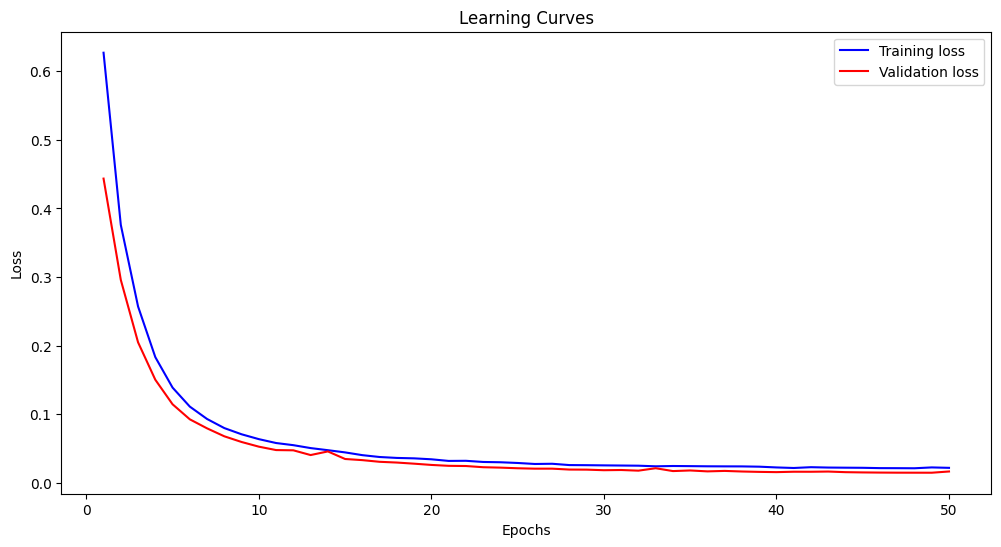

In [185]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Plotting
plt.figure(figsize=(12, 6))

plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Learning Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

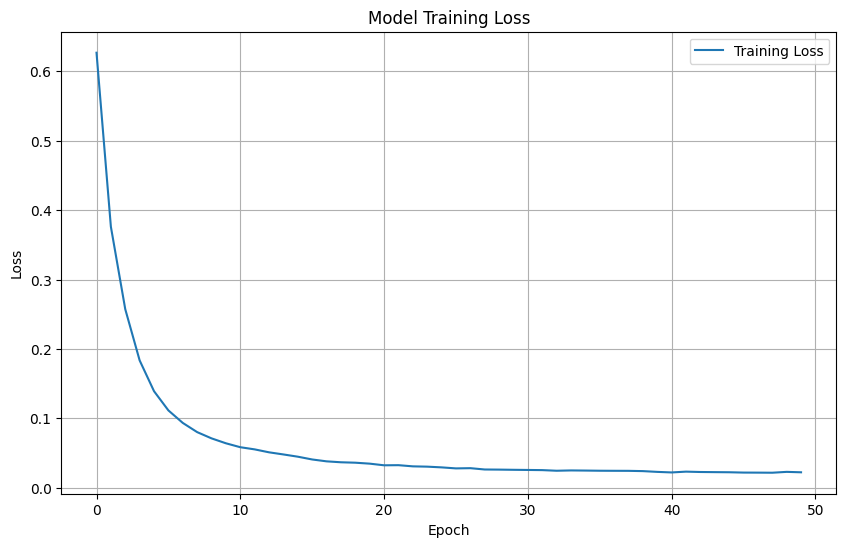

In [186]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.title('Model Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss'], loc='upper right')
plt.grid(True)
plt.show()


In [187]:
# Evaluate on test data
test_loss = model.evaluate(X_test, y_test)

# Predicting the test set results
y_pred = model.predict(X_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7022 - loss: 0.0137 
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


array([[1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [0.29015084],
       [0.29015084],
       [0.29015084],
       [0.290

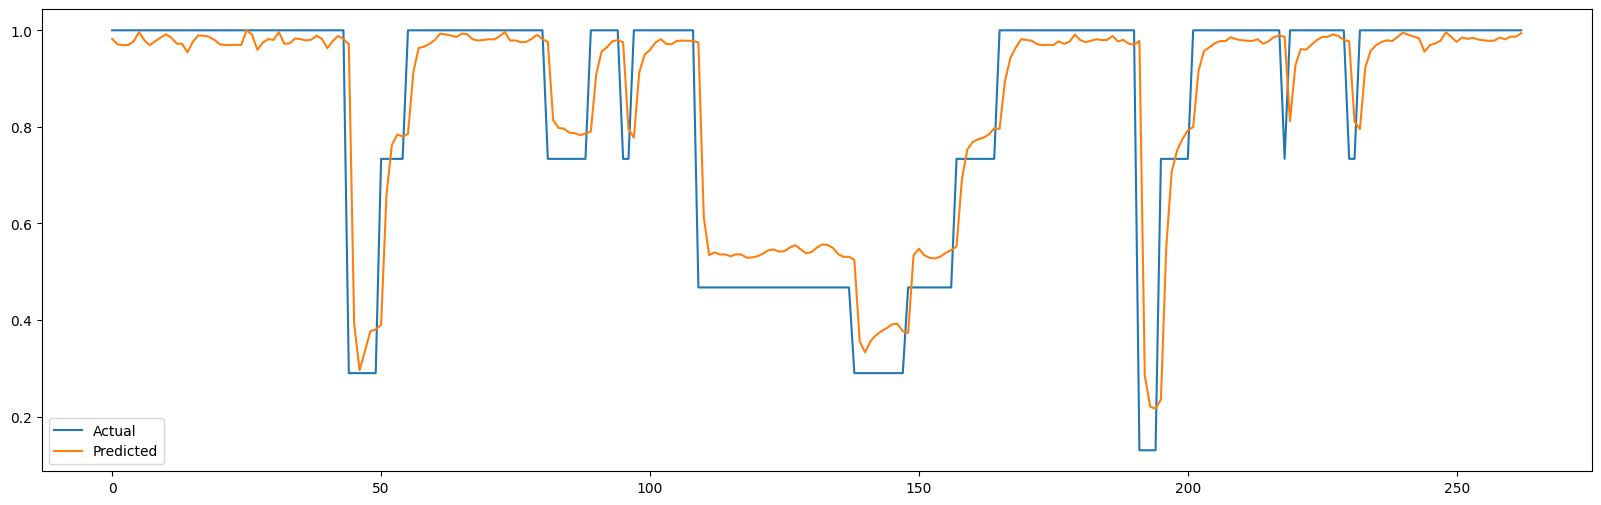

In [188]:
plt.figure(figsize=(20, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()


In [189]:
r2 = r2_score(y_test, y_pred)
r2

0.8216293588634164

In [190]:
np.square(mean_squared_error(y_pred, y_test))


0.00013140281439921552